In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ml_metrics import rmse
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Helper Functions

In [2]:
def rand_msng(feat_msng, df_obj, frac_msng=0.3, rand_state=99):

    try:
        df_msng = df_obj.sample(frac=frac_msng, random_state=rand_state)
        df_not_msng = df_obj[~df_obj.isin(df_msng)].dropna()
        df_msng[feat_msng] = np.nan
        df_msng[feat_msng] = df_msng[feat_msng].fillna(df_not_msng[feat_msng].median())
        df_new = pd.concat([df_msng, df_not_msng])
        df_new = df_new.sort_index()
    
    except:
        df_new = None
    
    return df_new
    
def add_to_results_df(df_full_res, frac, reg_obj, y_tst, y_predict):

        #get coefficients and feature names into dataframe
        df_coeff = pd.DataFrame()
        myList = reg_obj.coef_.tolist()
        for i in myList:
            data_dict = []
            var_index = reg_obj.coef_.tolist().index(i)
            tmp_dict = {data.feature_names[var_index]:i}
            data_dict.append(tmp_dict)
            df_tmp = pd.DataFrame(data_dict)
            df_coeff[data.feature_names[var_index]] = df_tmp[data.feature_names[var_index]].values
        
        #calculate model metrics and add to dataframe
        data_dict = [] #reuse existing data dictionary
        mae = mean_absolute_error(y_tst,y_predict)
        mse = mean_squared_error(y_tst,y_predict)
        rmse_val = rmse(y_tst,y_predict)
        r2 = r2_score(y_tst,y_predict)
        mae_diff = mae-orig_mae
        mse_diff = mse-orig_mse
        rsme_diff = rmse_val-orig_rmse_val
        r2_diff = r2-orig_r2
        tmp_dict = {'Scenario': 'CAR {}'.format(frac),'mae': mae, 'mse': mse, 'rmse_val':rmse_val, 'r2':r2, 'mae_diff':mae_diff, 'mse_diff':rsme_diff, 'r2_diff':r2_diff}
        data_dict.append(tmp_dict)
        df_metrics = pd.DataFrame(data_dict)
        #add coefficients to metrics
        df_metrics = df_metrics.join(df_coeff)
        df_metrics = pd.concat([df_full_res, df_metrics])
    
        return df_metrics

In [3]:
# Load in the dataset
data = datasets.fetch_california_housing()
print(data.data.shape)

(20640, 8)


In [4]:
print(data.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [5]:
df = pd.DataFrame(data.data)
df.columns = data.feature_names
df['MedHouseVal'] = data.target
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


In [7]:
#save original index of full data for later use
full_index = df.index.values.astype(int)
# Create training and testing sets 
train_set = df.sample(frac=0.7, random_state=100)
test_set = df[~df.isin(train_set)].dropna()
# Get the training and testing row indices 
train_index = train_set.index.values.astype(int)
test_index = test_set.index.values.astype(int)
print(train_set.shape[0])
print(test_set.shape[0])

14448
6192


In [8]:
# Converting the training and testing datasets back to matrix-formats
X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
Y_train = train_set.iloc[:, -1].values # returns the target-only
X_test = test_set.iloc[:, 0:8].values # ""
Y_test = test_set.iloc[:, -1].values # ""

In [9]:
#get baseline regression model and associated metrics
reg = LinearRegression(normalize=True).fit(X_train, Y_train)
print(reg.score(X_train, Y_train))
print(reg.coef_)
print(reg.intercept_)
print(reg.get_params())

0.6160214522398206
[ 4.59063361e-01  9.72601795e-03 -1.37408894e-01  8.20058010e-01
 -5.20832695e-06 -3.38987100e-03 -4.12859546e-01 -4.28244613e-01]
-36.614838649470215
{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True, 'positive': False}


In [10]:
Y_pred = reg.predict(X_test)

orig_mae = mean_absolute_error(Y_test,Y_pred)
orig_mse = mean_squared_error(Y_test,Y_pred)
orig_rmse_val = rmse(Y_test,Y_pred)
orig_r2 = r2_score(Y_test,Y_pred)

In [11]:
#get the baseline model metrics and add to results dataframe
#get coefficients and feature names into dataframe
df_coeff = pd.DataFrame()
myList = reg.coef_.tolist()
for i in myList:
    data_dict = []
    var_index = reg.coef_.tolist().index(i)
    tmp_dict = {data.feature_names[var_index]:i}
    data_dict.append(tmp_dict)
    df_tmp = pd.DataFrame(data_dict)
    df_coeff[data.feature_names[var_index]] = df_tmp[data.feature_names[var_index]].values

#calculate model metrics and add to dataframe
data_dict = [] #reuse existing data dictionary
orig_mae = mean_absolute_error(Y_test,Y_pred)
orig_mse = mean_squared_error(Y_test,Y_pred)
orig_rmse_val = rmse(Y_test,Y_pred)
orig_r2 = r2_score(Y_test,Y_pred)
#add metrics to dictionary and into dataframe
tmp_dict = {'Scenario': 'Baseline','mae': orig_mae, 'mse': orig_mse, 'rmse_val':orig_rmse_val, 'r2':orig_r2, 'mae_diff':0, 'mse_diff':0, 'r2_diff':0}
data_dict.append(tmp_dict)
df_overall = pd.DataFrame(data_dict)
#add coefficients to metrics
df_overall = df_overall.join(df_coeff)
df_overall

,Scenario,mae,mse,rmse_val,r2,mae_diff,mse_diff,r2_diff,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,Baseline,0.53676,0.556336,0.74588,0.58016,0,0,0,0.459063,0.009726,-0.137409,0.820058,-0.000005,-0.00339,-0.41286,-0.428245


In [12]:
msng_pcnt = [.01, .05, .1, .2, .33, .5]

for i in msng_pcnt:
    #get the data with imputed values
    df_new_msng = rand_msng('HouseAge', df, i)
    #get into training and test
    train_set = df_new_msng.iloc[train_index]
    test_set = df_new_msng.iloc[test_index]
    X_train = train_set.iloc[:, 0:8].values # returns the data; excluding the target
    Y_train = train_set.iloc[:, -1].values # returns the target-only
    X_test = test_set.iloc[:, 0:8].values # ""
    Y_test = test_set.iloc[:, -1].values # ""
    #fit model
    reg = LinearRegression(normalize=True).fit(X_train, Y_train)
    #predict on test
    Y_pred = reg.predict(X_test)
    #get model metrics into overall results dataframe
    df_overall = add_to_results_df(df_overall, i, reg, Y_test, Y_pred)

df_overall

,Scenario,mae,mse,rmse_val,r2,mae_diff,mse_diff,r2_diff,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,Baseline,0.536760,0.556336,0.745880,0.580160,0.000000,0.000000,0.000000,0.459063,0.009726,-0.137409,0.820058,-0.000005,-0.003390,-0.412860,-0.428245
0,CAR 0.01,0.536687,0.556214,0.745798,0.580252,-0.000073,-0.000082,0.000092,0.459035,0.009740,-0.137385,0.819406,-0.000005,-0.003389,-0.412892,-0.428331
0,CAR 0.05,0.536833,0.556399,0.745921,0.580113,0.000072,0.000042,-0.000047,0.459029,0.009817,-0.138002,0.821125,-0.000006,-0.003383,-0.413445,-0.429017
0,CAR 0.1,0.537678,0.557525,0.746676,0.579263,0.000918,0.000796,-0.000897,0.458394,0.009830,-0.138195,0.821223,-0.000008,-0.003366,-0.415804,-0.431688
0,CAR 0.2,0.538386,0.557392,0.746587,0.579364,0.001626,0.000707,-0.000796,0.457143,0.009980,-0.138240,0.819707,-0.000012,-0.003335,-0.419186,-0.435287
0,CAR 0.33,0.538364,0.558716,0.747473,0.578364,0.001604,0.001594,-0.001796,0.455779,0.009610,-0.139306,0.823141,-0.000018,-0.003275,-0.425501,-0.442244
0,CAR 0.5,0.539371,0.560840,0.748892,0.576761,0.002610,0.003013,-0.003399,0.453943,0.008302,-0.141054,0.823596,-0.000026,-0.003183,-0.434000,-0.451884


In [13]:
df_overall = df_overall.reset_index()

<AxesSubplot:>

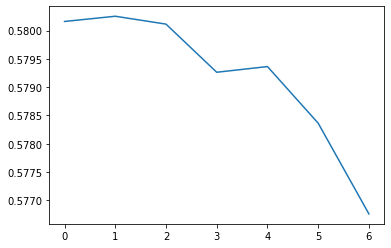

In [14]:
df_overall['r2'].plot()